In [ ]:
!pip install torchinfo

# Redes neuronales convolucionales (CNNs)

En la unidad anterior aprendimos cómo definir una red neuronal de múltiples capas, pero esas redes eran genéricas y no estaban especializadas en tareas de visión por computador. En esta unidad aprenderemos sobre las **Redes Neuronales Convolucionales (CNNs)**, que están diseñadas específicamente para visión por computador.

La visión por computador es diferente de la clasificación genérica, porque cuando tratamos de encontrar un cierto objeto en una imagen, estamos escaneando la imagen en busca de **patrones** específicos y sus combinaciones. Por ejemplo, al buscar un gato, podríamos primero buscar líneas horizontales, que pueden formar los bigotes, y luego cierta combinación de bigotes puede indicarnos que en realidad se trata de la imagen de un gato. La posición relativa y la presencia de ciertos patrones es importante, no su posición exacta en la imagen.

Para extraer patrones, usaremos la noción de **filtros convolucionales**. Pero primero, carguemos todas las dependencias y funciones que definimos en las unidades anteriores.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.06MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.19MB/s]


In [ ]:
# Helper function to display convolution filters
def plot_convolution(kernel, title, dataloader, n=5):
    kernel = kernel.unsqueeze(0).unsqueeze(0)  # shape: [1, 1, 3, 3]
    images, _ = next(iter(dataloader))  # obtener un batch
    images = images[:n]  # tomar las primeras n imágenes

    plt.figure(figsize=(n * 2, 4))

    # Mostrar imágenes originales
    for i in range(n):
        plt.subplot(3, n, i + 1)
        plt.imshow(images[i].squeeze(), cmap='viridis')
        plt.axis('off')
        if i == 0:
            plt.ylabel("Original", fontsize=10)

    # Aplicar convolución
    with torch.no_grad():
        filtered = F.conv2d(images, kernel, padding=1)

    # Mostrar imágenes filtradas
    for i in range(n):
        plt.subplot(3, n, n + i + 1)
        plt.imshow(filtered[i].squeeze(), cmap='viridis')
        plt.axis('off')
        if i == 0:
            plt.ylabel("Filtrada", fontsize=10)

    # Mostrar el kernel
    plt.subplot(3, n, 2 * n + 1)
    plt.imshow(kernel.squeeze().numpy(), cmap='viridis')
    plt.colorbar()
    plt.title("Kernel")
    plt.axis('off')

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Helper function to plot training results
def plot_results(history):
    train_acc, test_acc = zip(*history)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(test_acc, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Helper function to display a few images from the dataset
def display_dataset(dataset, classes):
    images, labels = next(iter(DataLoader(dataset, batch_size=8, shuffle=True)))
    fig, axs = plt.subplots(1, 8, figsize=(12, 2))
    for i in range(8):
        img = images[i]
        # Handle grayscale (1 channel) or RGB (3 channels)
        if img.shape[0] == 1:
            img = img.squeeze(0)  # [1, H, W] -> [H, W]
            axs[i].imshow(img, cmap='gray')
        else:
            img = img.permute(1, 2, 0)  # [C, H, W] -> [H, W, C]
            axs[i].imshow(img)
        axs[i].set_title(classes[labels[i].item()])
        axs[i].axis('off')
    plt.show()



## Filtros convolucionales

Los filtros convolucionales son pequeñas ventanas que se desplazan sobre cada píxel de la imagen y calculan un promedio ponderado de los píxeles vecinos.

Estos filtros se definen mediante matrices de coeficientes de pesos. Veamos algunos ejemplos de cómo se aplican dos filtros convolucionales diferentes sobre nuestras imágenes de dígitos manuscritos de MNIST:

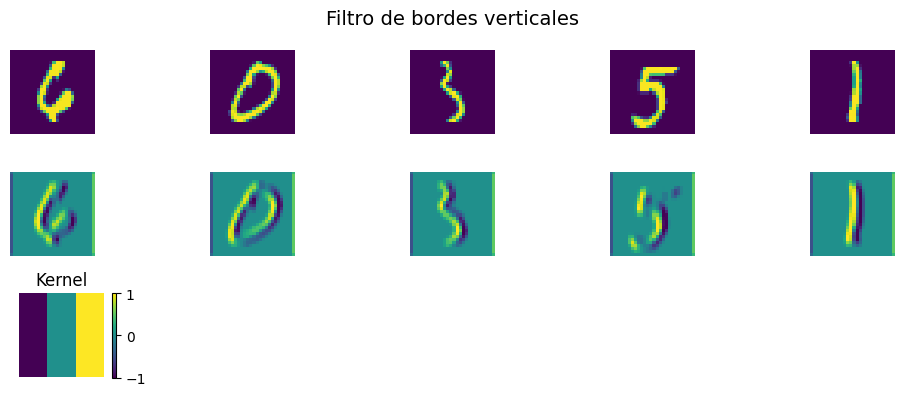

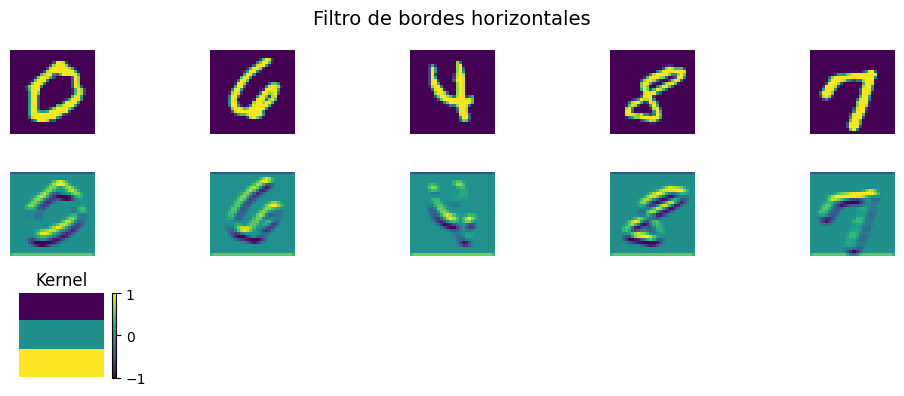

In [ ]:
plot_convolution(
    torch.tensor([[-1., 0., 1.],
                  [-1., 0., 1.],
                  [-1., 0., 1.]]),
    title="Filtro de bordes verticales",
    dataloader=train_loader
)

plot_convolution(
    torch.tensor([[-1., -1., -1.],
                  [ 0.,  0.,  0.],
                  [ 1.,  1.,  1.]]),
    title="Filtro de bordes horizontales",
    dataloader=train_loader
)


El primer filtro se llama **filtro de bordes verticales**, y está definido por la siguiente matriz:

$$
\left(
    \begin{matrix}
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
    \end{matrix}
\right)
$$

Cuando este filtro se desplaza sobre una región relativamente uniforme de píxeles, todos los valores se suman a 0. Sin embargo, cuando encuentra un borde vertical en la imagen, se genera un valor alto. Por eso, en las imágenes anteriores puedes ver que los bordes verticales están representados por valores altos y bajos, mientras que los bordes horizontales se promedian y desaparecen.

Lo contrario ocurre cuando aplicamos un filtro de bordes horizontales: las líneas horizontales se amplifican y las verticales se promedian.

En la visión por computador clásica, se aplicaban múltiples filtros a la imagen para generar características, que luego eran utilizadas por un algoritmo de aprendizaje automático para construir un clasificador. Sin embargo, en el aprendizaje profundo construimos redes que **aprenden** los mejores filtros convolucionales para resolver el problema de clasificación.

<img src="https://drive.google.com/uc?export=view&id=1HYUAPuhw3AR7kM6oyFaB-Agmp36JpXiq" />

Para lograrlo, introducimos las **capas convolucionales**.

## Capas convolucionales

Las capas convolucionales se definen usando la construcción `nn.Conv2d`. Necesitamos especificar lo siguiente:

* `in_channels` – número de canales de entrada. En nuestro caso estamos trabajando con imágenes en escala de grises, por lo tanto, el número de canales de entrada es 1.
* `out_channels` – número de filtros a utilizar. Usaremos 9 filtros diferentes, lo que le dará a la red muchas oportunidades para explorar qué filtros funcionan mejor para nuestro escenario.
* `kernel_size` – es el tamaño de la ventana deslizante. Normalmente se utilizan filtros de tamaño 3x3 o 5x5.

La CNN más simple contiene una capa convolucional. Dado un tamaño de entrada de 28x28, al aplicar nueve filtros de 5x5 terminamos con un tensor de tamaño 9x24x24 (el tamaño espacial es menor porque solo hay 24 posiciones donde una ventana deslizante de longitud 5 puede encajar dentro de 28 píxeles).

Después de la convolución, aplanamos el tensor de 9x24x24 en un solo vector de tamaño 5184, y luego agregamos una capa lineal para producir 10 clases. También utilizamos la función de activación `relu` entre capas.


In [ ]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5))
        self.fc = nn.Linear(5184,10)

    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = nn.Flatten(x)
        x = self.fc(x)
        return x

net = OneConv()

print(net)
print(sum(p.numel() for p in net.parameters() if p.requires_grad), "trainable parameters")


OneConv(
  (conv): Conv2d(1, 9, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=5184, out_features=10, bias=True)
)
52084 trainable parameters


Puedes ver que esta red contiene alrededor de 50 mil parámetros entrenables, en comparación con los aproximadamente 80 mil de las redes multicapa completamente conectadas. Esto nos permite obtener buenos resultados incluso con conjuntos de datos pequeños, ya que las redes convolucionales generalizan mucho mejor.

# Parámetros del entrenamiento

A continuación se muestra un ejemplo de cómo configurar el entorno y los componentes básicos necesarios para entrenar una red neuronal convolucional en PyTorch.

```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)  # asegurarse de que el modelo esté definido antes de esta línea
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
history = []
```

### Explicación:

- `device = torch.device(...)`  
  Esta línea selecciona automáticamente la GPU (`cuda`) si está disponible, o la CPU en caso contrario. Esto permite que el entrenamiento se realice de manera eficiente si hay una GPU disponible.

- `net = net.to(device)`  
  Mueve el modelo a la GPU (o CPU) seleccionada, de modo que las operaciones posteriores se ejecuten en el mismo dispositivo.

- `optimizer = torch.optim.Adam(...)`  
  Se utiliza el optimizador **Adam**, que ajusta los pesos de la red durante el entrenamiento. Se inicializa con los parámetros del modelo (`net.parameters()`) y una tasa de aprendizaje (`lr`) de 0.001.

- `loss_fn = nn.CrossEntropyLoss()`  
  Se define la función de pérdida **CrossEntropyLoss**, que es apropiada para tareas de clasificación multiclase como la clasificación de dígitos en MNIST.

- `history = []`  
  Se inicializa una lista vacía para almacenar el historial de entrenamiento, como las pérdidas por época, precisión, etc.

Este código prepara todo lo necesario para comenzar el entrenamiento del modelo en el siguiente paso.

In [ ]:
# Example training loop
n_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)  # ensure model is defined before this line
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
history = []

## Ciclo de entrenamiento completo

```python
for epoch in range(n_epochs):
    net.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    net.eval()
    with torch.no_grad():
        train_correct, test_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            train_correct += (outputs.argmax(1) == labels).sum().item()
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            test_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = train_correct / len(train_loader.dataset)
    test_acc = test_correct / len(test_loader.dataset)
    history.append((train_acc, test_acc))
    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

plot_results(history)
```

### Explicación:

- `for epoch in range(n_epochs):`  
  Inicia el bucle de entrenamiento para un número determinado de épocas.

- `net.train()`  
  Establece el modelo en modo de entrenamiento, activando características como *dropout* o *batch normalization* si están presentes.

- Bucle sobre `train_loader`:  
  Se recorren los lotes del conjunto de entrenamiento. Se trasladan las imágenes y etiquetas al dispositivo (CPU o GPU), se reinician los gradientes, se calcula la salida del modelo, la pérdida y se actualizan los pesos mediante retropropagación.

- `net.eval()` y `with torch.no_grad()`:  
  Se cambia el modelo al modo de evaluación y se desactiva el cálculo de gradientes para ahorrar memoria y acelerar la inferencia.

- Cálculo de precisión:  
  Se comparan las predicciones (`outputs.argmax(1)`) con las etiquetas reales para contar cuántas predicciones fueron correctas, tanto en entrenamiento como en prueba.

- Se calcula la precisión dividiendo los aciertos entre el total de datos, se guarda en el historial y se imprime el resultado de la época.

- `plot_results(history)`:  
  Esta función (definida previamente) se encarga de visualizar la evolución de la precisión a lo largo de las épocas.


Epoch 1: Train Acc = 0.9714, Test Acc = 0.9695
Epoch 2: Train Acc = 0.9802, Test Acc = 0.9751
Epoch 3: Train Acc = 0.9828, Test Acc = 0.9751
Epoch 4: Train Acc = 0.9853, Test Acc = 0.9802
Epoch 5: Train Acc = 0.9883, Test Acc = 0.9797


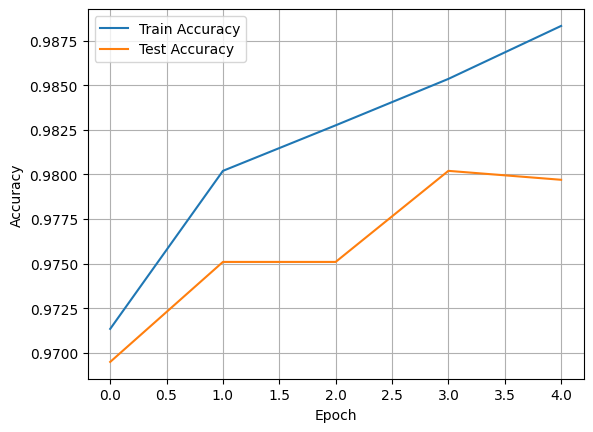

In [ ]:
for epoch in range(n_epochs):
    net.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    net.eval()
    with torch.no_grad():
        train_correct, test_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            train_correct += (outputs.argmax(1) == labels).sum().item()
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            test_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = train_correct / len(train_loader.dataset)
    test_acc = test_correct / len(test_loader.dataset)
    history.append((train_acc, test_acc))
    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

plot_results(history)

## Visualización y análisis

Como puedes ver, somos capaces de alcanzar una mayor precisión, y mucho más rápido, en comparación con las redes completamente conectadas vistas en la unidad anterior.

También podemos visualizar los pesos de nuestras capas convolucionales entrenadas, para tratar de entender mejor lo que está ocurriendo:

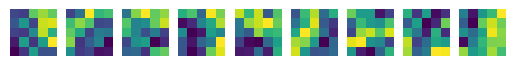

In [ ]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

Podemos observar que algunos de esos filtros parecen capaces de reconocer trazos oblicuos, mientras que otros parecen bastante aleatorios.

## CNNs multicapa y capas de agrupamiento (*pooling*)

Las primeras capas convolucionales detectan patrones primitivos, como líneas horizontales o verticales, pero podemos aplicar capas convolucionales adicionales sobre ellas para detectar patrones de nivel superior, como formas primitivas. Luego, más capas pueden combinar esas formas en partes más complejas de la imagen, hasta llegar al objeto final que estamos tratando de clasificar.

Al hacerlo, podemos aplicar una técnica adicional: reducir el tamaño espacial de la imagen. Una vez hemos detectado que existe un trazo horizontal dentro de una ventana deslizante de 3x3, no es tan importante saber en qué píxel exacto ocurrió. Por tanto, podemos **reducir la escala** de la imagen, lo cual se realiza mediante una de las siguientes **capas de agrupamiento (pooling)**:

* **Agrupamiento promedio (Average Pooling)**: toma una ventana deslizante (por ejemplo, de 2x2 píxeles) y calcula el promedio de los valores dentro de esa ventana.
* **Agrupamiento máximo (Max Pooling)**: reemplaza la ventana por el valor máximo. La idea detrás del max pooling es detectar la presencia de un patrón específico dentro de la ventana deslizante.

Por lo tanto, en una CNN típica se utilizan varias capas convolucionales, intercaladas con capas de agrupamiento que reducen las dimensiones espaciales de la imagen. También aumentamos el número de filtros, ya que a medida que los patrones se vuelven más complejos, hay más combinaciones posibles interesantes que queremos detectar.

<img src="https://drive.google.com/uc?export=view&id=1XjDnU_qpb4AuEwiC0RPg-jw6J_GC8NrU" />


Debido a la reducción progresiva de las dimensiones espaciales y el aumento en las dimensiones de características (filtros), esta arquitectura también se conoce como **arquitectura piramidal**.

In [ ]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = self.fc(x)
        return x

net = MultiLayerCNN()
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

## Observaciones sobre esta definición de red

Ten en cuenta algunos aspectos importantes sobre esta definición:

* En lugar de usar una capa `Flatten`, estamos aplanando el tensor dentro de la función `forward` utilizando la función `view`. Dado que la capa de aplanamiento no tiene pesos entrenables, no es esencial crear una instancia separada de capa dentro de nuestra clase.
* Usamos solo una instancia de la capa de *pooling* en nuestro modelo, también porque no contiene parámetros entrenables, y esta única instancia puede reutilizarse de manera efectiva.
* El número de parámetros entrenables (~8.5K) es dramáticamente menor que en los casos anteriores. Esto sucede porque las capas convolucionales en general tienen pocos parámetros, y la dimensionalidad de la imagen antes de aplicar la capa densa final se reduce significativamente. Un número pequeño de parámetros tiene un impacto positivo en nuestros modelos, ya que ayuda a prevenir el *overfitting* incluso con conjuntos de datos pequeños.


In [ ]:
# Example training loop
n_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)  # ensure model is defined before this line
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
history = []

Epoch 1: Train Acc = 0.9708, Test Acc = 0.9727
Epoch 2: Train Acc = 0.9799, Test Acc = 0.9819
Epoch 3: Train Acc = 0.9861, Test Acc = 0.9857
Epoch 4: Train Acc = 0.9883, Test Acc = 0.9873
Epoch 5: Train Acc = 0.9894, Test Acc = 0.9880


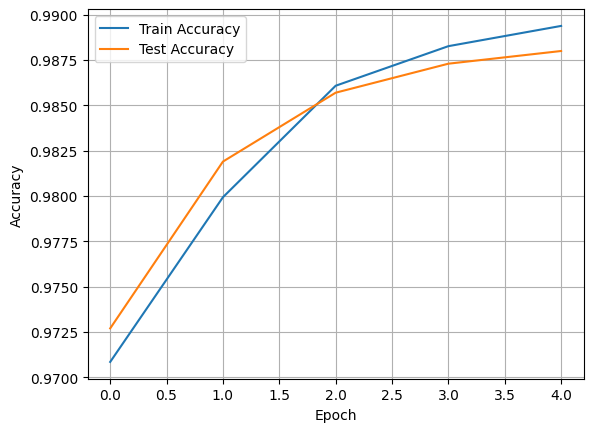

In [ ]:
for epoch in range(n_epochs):
    net.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    net.eval()
    with torch.no_grad():
        train_correct, test_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            train_correct += (outputs.argmax(1) == labels).sum().item()
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            test_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = train_correct / len(train_loader.dataset)
    test_acc = test_correct / len(test_loader.dataset)
    history.append((train_acc, test_acc))
    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

plot_results(history)

Lo que probablemente deberías notar es que somos capaces de alcanzar una mayor precisión que con solo una capa, y mucho más rápido —en solo 1 o 2 épocas. Esto significa que una arquitectura de red sofisticada necesita muchos menos datos para entender lo que está ocurriendo y para extraer patrones genéricos de nuestras imágenes.

---

## Jugando con imágenes reales del conjunto de datos CIFAR-10

Aunque nuestro problema de reconocimiento de dígitos manuscritos puede parecer un problema de juguete, ahora estamos listos para hacer algo más serio. Vamos a explorar un conjunto de datos más avanzado de imágenes de diferentes objetos, llamado [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). Este conjunto contiene 60,000 imágenes de tamaño 32x32, divididas en 10 clases.


In [ ]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


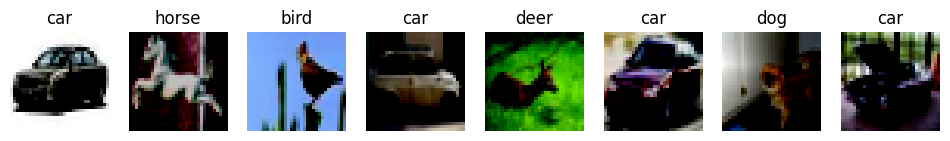

In [ ]:
display_dataset(trainset,classes=classes)

Una arquitectura bien conocida para CIFAR-10 se llama [LeNet](https://es.wikipedia.org/wiki/LeNet), y fue propuesta por *Yann LeCun*. Esta sigue los mismos principios que hemos descrito anteriormente, con la principal diferencia de que utiliza 3 canales de entrada (color) en lugar de 1 (escala de grises).


In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet()

summary(net,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

Entrenar esta red adecuadamente tomará una cantidad significativa de tiempo, y preferiblemente debería hacerse en un entorno con soporte para GPU.

In [ ]:
n_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)  # ensure model is defined before this line
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
history = []

Epoch 1: Train Acc = 0.3043, Test Acc = 0.3659
Epoch 2: Train Acc = 0.3912, Test Acc = 0.4750
Epoch 3: Train Acc = 0.4557, Test Acc = 0.5434
Epoch 4: Train Acc = 0.4814, Test Acc = 0.5637
Epoch 5: Train Acc = 0.5153, Test Acc = 0.5960


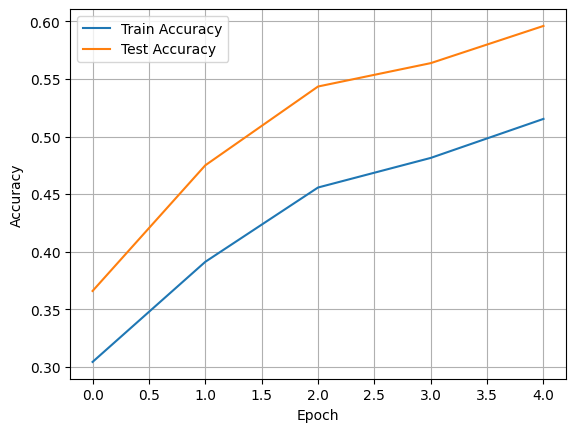

In [ ]:
for epoch in range(n_epochs):
    net.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    net.eval()
    with torch.no_grad():
        train_correct, test_correct = 0, 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            train_correct += (outputs.argmax(1) == labels).sum().item()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            test_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = train_correct / len(train_loader.dataset)
    test_acc = test_correct / len(test_loader.dataset)
    history.append((train_acc, test_acc))
    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

plot_results(history)

La precisión que hemos logrado con solo 3 épocas de entrenamiento no parece muy alta. Sin embargo, recuerda que una predicción al azar nos daría apenas un 10% de precisión, y que nuestro problema es considerablemente más difícil que la clasificación de dígitos en MNIST. Obtener más del 50% de precisión en tan poco tiempo de entrenamiento es un buen logro.

---

## Conclusiones

En esta unidad, hemos aprendido el concepto principal detrás de las redes neuronales para visión por computador: las redes convolucionales. Las arquitecturas reales que impulsan la clasificación de imágenes, la detección de objetos e incluso la generación de imágenes están todas basadas en CNNs, solo que con más capas y algunos trucos adicionales de entrenamiento.

